In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

In [233]:
class c_method:
    """This class will containt the information of a single method.
    The method is defined as a combination of a program with a particular set of keywords.
    So two different newtonX simulations with different timesteps are two different methods.
    The parameters of the simulation are variables of the class, the time dependent properties
    are in the self.data dataframe
    """

    def __init__(self, program: str = None) -> None:
        self.time_fs2au = 41.34137221718
        if program:
            self.add_program(program)
        

    def add_program(self, program: str) -> None:
        prog = program.split(sep='_')

        if (prog[0].lower() == 'newtonx' 
         or prog[0].lower() == 'nx'):
            self.prog_name = 'NewtonX'
            self.set_nx_defaults()

        elif (prog[0].lower() == 'qdct'):
            self.prog_name = 'qdct'
            self.set_qdct_defaults()

        elif (prog[0].lower() == 'fms'
           or prog[0].lower() == 'fms90'):
           self.prog_name = 'fms'
           self.set_fms_defaults()
        elif (prog[0].lower() == 'ref'):
            self.prog_name = 'ref'

        else:
            self.prog_name = prog[0]

        if len(prog) == 2:
            self.prog_version = prog[1]
        else:
            self.prog_version = 'not specified'


    def print_program(self):
        print(f'Program used: {self.prog_name} Version {self.prog_version}')

    def get_program(self) -> (str, str):
        return self.prog_name, self.prog_version

    def add_description(self, description: str):
        self.description = description

    def add_path(self, path: str):
        self.path = path

    def get_path(self) -> str:
        return self.path

    def print_path(self):
        print(self.path)



    ######## DYNAMICS PARAMTERS
    def set_timestep(self, ts: float) -> None:
        self.time_step = ts

    def get_timestep(self) -> float:
        return self.time_step

    def set_subtimestep(self, sub: float) -> None:
        self.subtimestep = sub

    def set_substeps(self, sub:int) -> None:
        self.subtimestep = self.time_step/sub

    def get_subtimestep(self) -> float:
        return self.subtimestep

    def set_coupling_thresh(self, thresh) -> None:
        self.coupling_thresh = thresh

    def get_coupling_thresh(self) -> float:
        return self.coupling_thresh
    
    def set_ovrl_max(self, overlap) -> None:
        self.ovrl_max = overlap

    def get_ovrl_max(self) -> float:
        return self.ovrl_max

    def set_ovrl_substitute(self, overlap) -> None:
        self.ovrl_substitute = overlap

    def get_ovrl_substitute(self) -> float:
        return self.ovrl_substitute



    ######## PROGRAM IO
    def print_prog_params(self) -> None:
        if self.prog_name == 'NewtonX':
            self.print_nx_params()
        elif self.prog_name == 'qdct':
            self.print_qdct_params()
        elif self.prog_name == 'fms':
            self.print_fms_params()


    def get_prog_params(self) -> dict:
        params = dict()
        params['data'] = list(self.df.columns)
        if self.prog_version == 'not specified':
            params['program'] = f'{self.prog_name}'
        else:
            params['program'] = f'{self.prog_name}_{self.prog_version}'

        if self.prog_name == 'NewtonX':
            params['timestep'] = self.time_step
            params['subtimestep'] = self.subtimestep
            params['decoherence'] = self.decoherence

        elif self.prog_name == 'qdct':
            params['timestep'] = self.time_step
            params['subtimestep'] = self.subtimestep
            params['classical'] = self.classical_calc
            params['coup_thresh'] = self.coupling_thresh
            params['ovrlp_max'] = self.ovrl_max
            params['ovrlp_subst'] = self.ovrl_substitute
        
        elif self.prog_name == 'fms':
            params['timestep'] = self.time_step
            params['subtimestep'] = self.subtimestep
            params['coup_thresh'] = self.coupling_thresh
            params['ovrlp_max'] = self.ovrl_max

        return params



    ######## NEWTONX PARAMETERS
    def set_nx_defaults(self) -> None:
        self.set_timestep(0.5)
        self.set_decoherence('ene')
        self.set_subtimestep(0.025)


    def read_nx_params(self, path):
        file = path.split(sep='/')[-1]
        if not os.path.isfile(path):
            print(f'{file} not found in root directory')
            return

        print(f'Reading simulation parameters from {file}')
        with open(path, 'r') as f:
            for line in f.readlines():
                try:
                    key = line.split()[0]
                    val = line.split()[2]
                except:
                    continue

                if key == 'dt':
                    self.set_timestep(float(val))
                elif key == 'decohmod':
                    if val == '1':
                        self.set_decoherence('off')
                    elif val == '2':
                        self.set_decoherence('ene')
                    elif val == '3':
                        self.set_decoherence('ovl')
                elif key == 'ms':
                    self.set_subtimestep(self.time_step/int(val))


    def set_decoherence(self, deco: str) -> None:
        self.decoherence = deco

    def get_decoherence(self) -> None:
        return self.decoherence

    def print_nx_params(self) -> None:
        print(f'Time step: {self.time_step} fs')
        print(f'Decoherence: {self.decoherence}')
        print(f'Sub time step: {self.subtimestep}')



    ######## QDCT PARAMETERS
    def set_classical_calculation(self, classical: str) -> None:
        self.classical_calc = classical

    def set_qdct_defaults(self) -> None:
        self.set_timestep(0.5)
        self.set_subtimestep(0.5)
        self.set_coupling_thresh(0.08)
        self.set_ovrl_max(0.7)
        self.set_ovrl_substitute(0.8)


    def read_qdct_params(self, path):
        file = path.split(sep='/')[-1]
        if not os.path.isfile(path):
            print(f'{file} not found in root directory')
            return

        print(f'Reading simulation parameters from {file}')
        with open(path, 'r') as f:
            for line in f.readlines():
                if line[0] == '#':
                    continue
                elif 'set_overlap_tol' in line:
                    self.set_ovrl_max(float(line[23:-2]))
                elif 'set_sub_overlap' in line:
                    self.set_ovrl_substitute(float(line[27:-2]))
                elif 'set_spawning_coup_tol' in line:
                    self.set_coupling_thresh(float(line[29:-2]))

        try:
            with open('/'.join(path.split(sep='/')[:-1])+'/qdct.log') as f:
                i = 0
                for line in f.readlines():
                    if 'actual timestep' in line:
                        self.set_timestep(float(line.split()[2])/self.time_fs2au)
                    elif 'new dt' in line:
                        self.set_subtimestep(float(line.split()[2])/self.time_fs2au)
                    i += 1
                    if i > 1000:
                        break
        except:
            print('Problem reading timestep from qdct.log')


    def print_qdct_params(self) -> None:
        print(f'Time step: {self.time_step} fs')
        print(f'Sub time step: {self.subtimestep}')
        print(f'Classical calculation: {self.classical_calc}')
        print(f'Coupling Threshold: {self.coupling_thresh}')
        print(f'Substitution overlap: {self.ovrl_substitute}')
        print(f'Maximum overlap: {self.ovrl_max}')



    ######## FMS90 PARAMETERS
    def set_fms_defaults(self) -> None:
        self.set_timestep(1./self.time_fs2au)
        self.set_subtimestep(0.1/self.time_fs2au)
        self.set_coupling_thresh(0.008)
        self.set_ovrl_max(0.5)


    def read_fms_params(self, path):
        file = path.split(sep='/')[-1]
        if not os.path.isfile(path):
            print(f'{file} not found in root directory')
            return

        print(f'Reading simulation parameters from {file}')
        with open(path, 'r') as f:
            for line in f.readlines():
                try:
                    key = line.split()[0].split(sep='=')[0]
                    val = line.split()[0].split(sep='=')[2]
                except:
                    continue

                if key == 'TimeStep':
                    self.set_timestep(float(val)/self.time_fs2au)
                elif key == 'MinTimeStep':
                    self.subtimestep(float(val)/self.time_fs2au)
                elif key == 'CSThresh':
                    self.set_coupling_thresh(float(val))
                elif key == 'OMax':
                    self.set_ovrl_max(float(val))


    def print_fms_params(self) -> None:
        print(f'Time step: {self.time_step} fs')
        print(f'Sub time steps: {self.subtimestep}')
        print(f'Coupling Threshold: {self.coupling_thresh}')
        print(f'Maximum overlap: {self.ovrl_max}')



    ######## PARSE DATA
    def parse_average_pop(self) -> None:
        if self.prog_name == 'NewtonX':
            self.read_nx_params(f'{self.path}/nx_exported_config.nml')
            self.parse_nx_average_pop()
        elif self.prog_name == 'qdct':
            self.read_qdct_params(f'{self.path}/qdct.py')
            self.parse_qdct_average_pop()
        elif self.prog_name == 'fms':
            self.read_fms_params(f'{self.path}/Control.dat')
            self.parse_fms_average_pop()
        elif self.prog_name == 'ref':
            self.parse_ref_average_pop()
       

    def parse_nx_average_pop(self) -> None:
        try:
            self.df = pd.read_csv(f'{self.path}/populations.csv',
                                    names=['time', 'S0 pop', 'S1 pop'],
                                    skiprows=1)

            self.df['norm'] = self.df['S0 pop'] + self.df['S1 pop']
        except:
            print(f'no {self.path}/populations.csv')


    def parse_qdct_average_pop(self) -> None:
        try:
            self.df = pd.read_csv(f'{self.path}/elec_pop.dat',
                                    names=['time', 'norm', 'S0 pop', 'S1 pop'],
                                    sep='\s+',
                                    skiprows=1)
            self.df = self.df[['time', 'S0 pop', 'S1 pop', 'norm']]
            
            self.df['time'] = self.df['time']/self.time_fs2au
        except:
            print(f'no file {self.path}/elec_pop.dat')


    def parse_fms_average_pop(self) -> None:
        try:
            self.df = pd.read_csv(f'{self.path}/populations.csv',
                                    names=['time', 'S0 pop', 'S1 pop', 'norm'],
                                    skiprows=1)

            self.df['time'] = self.df['time']/self.time_fs2au
        except:
            print(f'no {self.path}/populations.csv')


    def parse_ref_average_pop(self) -> None:
        try:
            s0 = pd.read_csv(f'{self.path}/Federica_exact_S0.txt',
                                    names=[ 'time', 'S0 pop'])
            s1 = pd.read_csv(f'{self.path}/Federica_exact_S1.txt',
                                    names=[ 'time', 'S1 pop'])

            self.df = pd.concat([s0, s1])
            self.df['time'] = self.df['time']/self.time_fs2au
            self.df['norm'] = self.df['S0 pop'] + self.df['S1 pop']
        except:
            print(f'Problem reading the reference files in {self.path}')

    def get_data(self):
        try:
            return self.df
        except:
            print(f'no data for this method')

In [234]:
class c_init_cond:
    """class to collet the different methods used of an individual initial condition
    the method class is indicated by a dictionary
    """
    def __init__(self, condition: str) -> None:
        self.initial_cond = condition
        self.methods = dict()


    def add_method(self, method_name: str, method_class: c_method = None) -> None:
        if method_class:
            self.methods[method_name] = method_class
        else:
            self.methods[method_name] = c_method()


    def get_method(self, method_name: str) -> c_method:
        try:
            return self.methods[method_name]
        except:
            print(f'No method {method_name}')

    def get_method_names(self) -> list:
        return list(self.methods.keys())

    def summarize_methods(self, cond_name) -> list:
        summary = []
        for method_name, meth in self.methods.items():
            summary.append(meth.get_prog_params())
            summary[-1]['init_cond'] = self.initial_cond
            summary[-1]['method_name'] = method_name
            summary[-1]['cond_name'] = cond_name

        return summary


In [235]:
class c_model:
    """Class to collet the different innitial conditions for an individual analytical model
    the initial conditions are pointed by a dictionary
    """

    def __init__(self, model: str) -> None:
        self.model = model
        self.conditions = dict()


    def add_init_cond(self, cond_name: str, cond_class: c_init_cond = None) -> None:
        if cond_name in self.conditions:
            if cond_class:
                for meth in cond_class.get_method_names():
                    self.conditions[cond_name].add_method(meth, cond_class.get_method(meth))
        else:
            if cond_class:
                self.conditions[cond_name] = cond_class
            else:
                self.conditions[cond_name] = c_init_cond()


    def get_init_cond(self, cond_name: str) -> c_init_cond:
        try:
            return self.conditions[cond_name]
        except:
            print(f'No initial condition {cond_name}')

    def summarize(self) -> None:
        self.summary = []

        for name, cond in self.conditions.items():
            self.summary= self.summary + cond.summarize_methods(name)

        self.summary = pd.DataFrame(self.summary).fillna('')

    def get_summary(self) -> pd.DataFrame:
        try:
            return self.summary
        except:
            self.summarize()
            return self.summary

    def filter_data(self, filter_values: dict, exclude_values: dict = None) -> pd.DataFrame:
        query = ''

        for key, val in filter_values.items():
            query += f" and {key} == {val}"

        if exclude_values:
            for key, val in exclude_values.items():
                query += f" and {key} != {val}"

        query = query[5:]
        
        return pd.DataFrame(self.get_summary().query(query))


    def get_data(self, filter_values: dict, exclude_values: dict = None) -> pd.DataFrame:
        data = self.filter_data(filter_values, exclude_values)

        df_list = []
        key_list = []
        for meth, cond in zip(data.method_name, data.cond_name):
            df_list.append(self.conditions[cond].get_method(meth).get_data())
            key_list.append(f'{cond}_{meth}')

        df = pd.concat(df_list, axis=1, keys=key_list).fillna('')
        return df

    def plot(self, filter_values: dict, properties: list, 
                exclude_values: dict = None, file_name: str = False) -> None:
        data = self.filter_data(filter_values, exclude_values)

        for meth, cond in zip(data.method_name, data.cond_name):
            tmp_data = self.conditions[cond].get_method(meth).get_data()

            for p in properties:
                if p in tmp_data:
                    plt.plot(tmp_data['time'], tmp_data[p], label=f'{p}_{cond}_{meth}')

        plt.legend()
        plt.xlabel('time (fs)')
        if file_name:
            plt.savefig(f'{file_name}.png', dpi=300)
        # plt.show()


In [236]:
def populate_tully(model) -> c_model:
    if model == 1:
        r_path = '/data/Rafael/Projects/08-QDCT/data/01-tully_1'
        ref_cond = ['mom10', 'mom25']
        dict_init_cond = {'mom5' : '02-mom_5',
                        'mom8' : '03-mom_8',
                        'mom10': '04-mom_10',
                        'mom15': '05-mom_15',
                        'mom20': '06-mom_20',
                        'mom25': '07-mom_25'}
    elif model == 2:
        r_path = '/data/Rafael/Projects/08-QDCT/data/02-tully_2'
        ref_cond = ['mom16', 'mom30']
        dict_init_cond = {'mom5' : '02-mom_5',
                        'mom8' : '03-mom_8',
                        'mom10': '04-mom_10',
                        'mom16': '05-mom_16',
                        'mom20': '06-mom_20',
                        'mom30': '07-mom_30'}
    elif model == 3:
        r_path = '/data/Rafael/Projects/08-QDCT/data/03-tully_3'
        ref_cond = ['mom10', 'mom30']
        dict_init_cond = {'mom5' : '02-mom_5',
                        'mom8' : '03-mom_8',
                        'mom10': '04-mom_10',
                        'mom15': '05-mom_15',
                        'mom20': '06-mom_20',
                        'mom30': '07-mom_30'}


    tully = c_model(f'tully {model}')

    print(f'Starting to read the reference data')
    for key in ref_cond:
        print(f'Reading initial condition: {key}')
        tmp_meth = c_method('ref')
        tmp_meth.add_path(f'{r_path}/{dict_init_cond[key]}/10-Federicas')
        tmp_meth.parse_average_pop()

        init_cond = c_init_cond(key)
        init_cond.add_method('exact', tmp_meth)

        tully.add_init_cond(key, init_cond)

    print('')
    print(f'Starting to read newtonX trajectories')
    for key, val in dict_init_cond.items():
        print(f'Reading initial condition: {key}')
        total_path = f'{r_path}/{val}/01-NX_NS/01-ts0.1fs/01-decon_mson'
        try:
            cmd = f'cp {total_path}/TRAJECTORIES/TRAJ1/nx_exported_config.nml {total_path}'
            os.system(cmd)
        except:
            print('Failed to copy user_exported_config.nml to root')

        tmp_meth = c_method('nx_ns')
        tmp_meth.add_path(total_path)
        tmp_meth.parse_average_pop()
        # tmp_meth.set_timestep(0.1)

        init_cond = c_init_cond(key)
        init_cond.add_method('nx', tmp_meth)

        tully.add_init_cond(key, init_cond)

    print('')
    print(f'Starting to read qdct trajectories')
    for key, val in dict_init_cond.items():
        print(f'Reading initial condition: {key}')

        tmp_meth = c_method('qdct')
        tmp_meth.add_path(f'{r_path}/{val}/05-qdct_nx')
        tmp_meth.parse_average_pop()
        # tmp_meth.set_substeps(10)
        tmp_meth.set_classical_calculation('nx')

        init_cond = c_init_cond(key)
        init_cond.add_method('qdct', tmp_meth)

        tully.add_init_cond(key, init_cond)

    print('')
    print(f'Starting to read fms trajectories')
    for key, val in dict_init_cond.items():
        print(f'Reading initial condition: {key}')

        tmp_meth = c_method('fms')
        tmp_meth.add_path(f'{r_path}/{val}/03-FMS90')
        tmp_meth.parse_average_pop()
        # tmp_meth.set_substeps(4)

        init_cond = c_init_cond(key)
        init_cond.add_method('fms', tmp_meth)

        tully.add_init_cond(key, init_cond)

    return tully

In [237]:
def save_model(model: c_model, f_name: str) -> None:
    with open(f'{f_name}.pikle', 'wb') as data_file:
        pickle.dump(model, data_file)

def read_model(f_name: str) -> c_model:
    with open(f'{f_name}.pikle', 'rb') as data_file:
        return pickle.load(data_file)

In [238]:
def filter_data(filter_values: dict, full_data: pd.DataFrame) -> pd.DataFrame:
    query = ''

    for key, val in filter_values.items():
        query += f" and {key} == {val}"

    query = query[5:]
    
    return pd.DataFrame(full_data.query(query))

In [242]:
t3 = populate_tully(3)

Starting to read the reference data
Reading initial condition: mom10
Reading initial condition: mom30

Starting to read newtonX trajectories
Reading initial condition: mom5
Reading simulation parameters from nx_exported_config.nml
Reading initial condition: mom8
Reading simulation parameters from nx_exported_config.nml
Reading initial condition: mom10
Reading simulation parameters from nx_exported_config.nml
Reading initial condition: mom15
Reading simulation parameters from nx_exported_config.nml
Reading initial condition: mom20
Reading simulation parameters from nx_exported_config.nml
Reading initial condition: mom30
Reading simulation parameters from nx_exported_config.nml

Starting to read qdct trajectories
Reading initial condition: mom5
Reading simulation parameters from qdct.py
Reading initial condition: mom8
Reading simulation parameters from qdct.py
Reading initial condition: mom10
Reading simulation parameters from qdct.py
Reading initial condition: mom15
Reading simulation p

In [244]:
t3.get_summary()

,data,program,init_cond,method_name,cond_name,timestep,decoherence,subtimestep,classical,coup_thresh,ovrlp_max,ovrlp_subst
0,"[time, S0 pop, S1 pop, norm]",ref,mom10,exact,mom10,,,,,,,
1,"[time, S0 pop, S1 pop, norm]",NewtonX_ns,mom10,nx,mom10,0.1,off,0.005,,,,
2,"[time, S0 pop, S1 pop, norm]",qdct,mom10,qdct,mom10,0.5,,0.5,nx,0.008,0.7,0.5
3,"[time, S0 pop, S1 pop, norm]",fms,mom10,fms,mom10,0.024189,,0.002419,,0.008,0.5,
4,"[time, S0 pop, S1 pop, norm]",ref,mom30,exact,mom30,,,,,,,
5,"[time, S0 pop, S1 pop, norm]",NewtonX_ns,mom30,nx,mom30,0.1,off,0.005,,,,
6,"[time, S0 pop, S1 pop, norm]",qdct,mom30,qdct,mom30,0.1,,0.02,nx,0.008,0.7,0.5
7,"[time, S0 pop, S1 pop, norm]",fms,mom30,fms,mom30,0.024189,,0.002419,,0.008,0.5,
8,"[time, S0 pop, S1 pop, norm]",NewtonX_ns,mom5,nx,mom5,0.1,off,0.005,,,,
9,"[time, S0 pop, S1 pop, norm]",qdct,mom5,qdct,mom5,0.1,,0.02,nx,0.008,0.7,0.5


In [241]:
save_model(t1, 'tully_1')

In [218]:
get_vals = {
    # 'decoherence': "'off'",
    'init_cond': "'mom16'",
    'program': "'qdct'",
    }
exclude_vals = {
    'program': "'ref'"
}
t2.filter_data(get_vals)

,data,program,init_cond,method_name,cond_name,timestep,decoherence,subtimestep,classical,coup_thresh,ovrlp_max,ovrlp_subst
3,"[time, S0 pop, S1 pop, norm]",fms,mom16,fms,mom16,0.024189,,0.002419,,0.008,0.5,


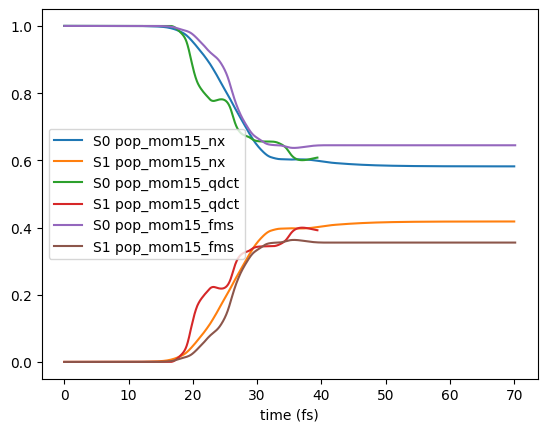

In [232]:
get_vals = {'init_cond': "'mom15'",
            # 'program': "'qdct'",
}
exclude_vals = {
    'program': "'ref'"
}
data = ['S0 pop', 'S1 pop']

t1.plot(get_vals, data, exclude_values=None)